<a href="https://colab.research.google.com/github/Taejin1221/MachineLearning/blob/master/TrajectoryAugmentation/VAE(Dotsize_3x3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, glob
import numpy as np
import pandas as pd
import convertImage

SIZE = 512

In [2]:
files = glob.glob( '*csv' )

trainSize = int( len( files ) * 0.8 )
trainFiles, testFiles = files[ : trainSize], files[trainSize : ]

X_train, Y_train = [ ], [ ]
for file in trainFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = convertImage.coorMaxMin( csv_file )
	X_train.append( convertImage.map2Image_remove( *maxmin, csv_file ) )
	Y_train.append( convertImage.map2Image( *maxmin, csv_file ) )

X_test = [ ]
for file in testFiles:
	csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'num' ], header = None )
	maxmin = convertImage.coorMaxMin( csv_file )
	X_test.append( convertImage.map2Image_remove( *maxmin, csv_file ) )

In [3]:
print( len( X_train ), len( X_test ) )

52 14


In [4]:
X_train, Y_train = np.array( X_train ), np.array( Y_train )
X_test = np.array( X_test )

X_train = X_train / 255.
Y_train = Y_train / 255.
X_test = X_test / 255.

X_train = np.reshape( X_train, ( len( X_train ), SIZE, SIZE, 1 ) )
Y_train = np.reshape( Y_train, ( len( Y_train ), SIZE, SIZE, 1 ) )
X_test = np.reshape( X_test, ( len( X_test ), SIZE, SIZE, 1 ) )

In [5]:
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

def ComputeLatent( x ):
	mu, sigma = x
	eps = K.random_normal( shape = ( K.shape( mu )[0], K.int_shape( mu )[1] ) )

	return mu + K.exp( sigma / 2 ) * eps

latent = 2

In [6]:
encoder_input = layers.Input( shape = ( SIZE, SIZE, 1 ) )
encoder_conv = layers.Conv2D( 128, 3, 2, 'same', activation = 'relu' )( encoder_input )
encoder_conv = layers.Conv2D( 256, 3, 2, 'same', activation = 'relu' )( encoder_conv )

encoder = layers.Flatten()( encoder_conv )

mu = layers.Dense( latent )( encoder )
sigma = layers.Dense( latent )( encoder )

latent_space = layers.Lambda( ComputeLatent, output_shape = ( latent, ) )( [ mu, sigma ] )

conv_shape = K.int_shape( encoder_conv )

In [7]:
decoder_input = layers.Input( shape = ( latent, ) )

units = conv_shape[1] * conv_shape[2] * conv_shape[3]
decoder = layers.Dense( units, 'relu' )( decoder_input )
decoder = layers.Reshape( ( conv_shape[1], conv_shape[2], conv_shape[3] ) )( decoder )

decoder_conv = layers.Conv2DTranspose( 256, 3, 2, 'same', activation = 'relu' )( decoder )
decoder_conv = layers.Conv2DTranspose( 128, 3, 2, 'same', activation = 'relu' )( decoder_conv )
decoder_output = layers.Conv2DTranspose( 1, 3, padding = 'same', activation = 'sigmoid' )( decoder_conv )

In [8]:
encoder = keras.models.Model( encoder_input, latent_space, name = 'Encoder' )
decoder = keras.models.Model( decoder_input, decoder_output, name = 'Decoder' )

vae = keras.models.Model( encoder_input, decoder( encoder( encoder_input ) ), name = 'VAE' )

# encoder.summary()
# decoder.summary()
# vae.summary()

In [9]:
def KL_Reconstruction_Loss( true, pred ):
	reconstruction_loss = keras.losses.binary_crossentropy( K.flatten( true ), K.flatten( pred ) ) * SIZE * SIZE

	kl_loss = 1 + sigma - K.square( mu ) - K.exp( sigma )
	kl_loss = K.sum( kl_loss, axis = -1 )
	kl_loss *= -0.5

	return K.mean( reconstruction_loss + kl_loss )

vae.compile( 'adam', KL_Reconstruction_Loss, metrics = [ 'acc' ] )

In [10]:
BATCH_SIZE = 10
EPOCHS = 30

history = vae.fit( X_train, Y_train, BATCH_SIZE, EPOCHS )

Train on 52 samples
Epoch 1/30
52/52 [==============================] - 14s 270ms/sample - loss: 150481.7763 - acc: 0.8829
Epoch 2/30
52/52 [==============================] - 6s 107ms/sample - loss: 31960.3693 - acc: 0.9927
Epoch 3/30
52/52 [==============================] - 6s 110ms/sample - loss: 14136.6369 - acc: 0.9927
Epoch 4/30
52/52 [==============================] - 6s 112ms/sample - loss: 11630.1892 - acc: 0.9927
Epoch 5/30
52/52 [==============================] - 6s 114ms/sample - loss: 11322.1452 - acc: 0.9927
Epoch 6/30
52/52 [==============================] - 6s 116ms/sample - loss: 10865.0661 - acc: 0.9927
Epoch 7/30
52/52 [==============================] - 6s 118ms/sample - loss: 10691.9304 - acc: 0.9927
Epoch 8/30
52/52 [==============================] - 6s 117ms/sample - loss: 10135.4596 - acc: 0.9927
Epoch 9/30
52/52 [==============================] - 6s 115ms/sample - loss: 10275.4356 - acc: 0.9927
Epoch 10/30
52/52 [==============================] - 6s 112ms/sample 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


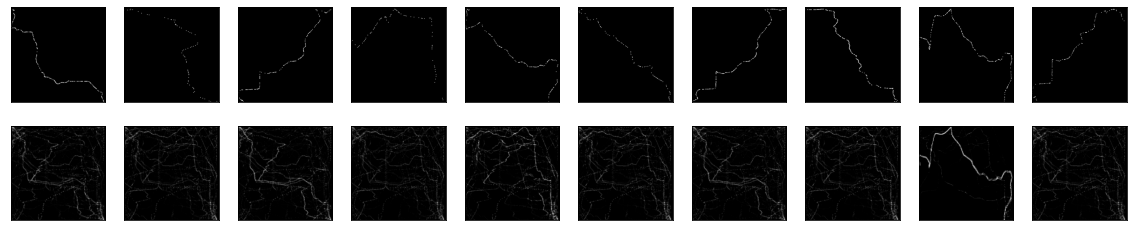

In [11]:
decoded_img = vae.predict( X_test )

import matplotlib.pyplot as plt

n = 10
plt.figure( figsize = ( 20, 4 ) )
for i in range( n ):
	ax = plt.subplot( 2, n, i + 1 )
	plt.imshow( X_test[i].reshape( SIZE, SIZE ) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

	ax = plt.subplot( 2, n, n + i + 1 )
	plt.imshow( decoded_img[i].reshape( SIZE, SIZE ) )
	plt.gray()

	ax.get_xaxis().set_visible( False )
	ax.get_yaxis().set_visible( False )

plt.savefig( 'Result.png', dpi = 300 )
plt.show()